In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
import matplotlib.animation as animation
import datetime as datetime
sys.path.insert(1, '../../functions')
from ParticlePlotFunctions import *
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
# produce unbeaching map

Ufiles = '../../input/modelfields/MITgcm4km/RGEMS_2008_Surf.nc'
Xfiles = '../../input/modelfields/MITgcm4km/RGEMS3_Surf_grid.nc'

date = 200

dfile = Dataset(Ufiles)
Uvel = dfile.variables['UVEL'][date,:,:]
Vvel = dfile.variables['VVEL'][date,:,:]
dfile = Dataset(Xfiles)
bathy = dfile.variables['maskC'][0,:,:]
XG = dfile.variables['XG'][:]
YG = dfile.variables['YG'][:]
XC = dfile.variables['XC'][:]
YC = dfile.variables['YC'][:]

unBeachU = np.zeros(Uvel.shape)
unBeachV = np.zeros(Vvel.shape)
for j in range(1, Uvel.shape[0]-2):
    for i in range(1, Uvel.shape[1]-2):
        if Uvel[j, i] == 0 and Uvel[j, i+1] == 0 and Vvel[j, i] == 0 and Vvel[j+1, i] == 0:
            if abs(Uvel[j, i-1]) > 1e-10:
                unBeachU[j, i] = -1
            if abs(Uvel[j, i+2]) > 1e-10:
                unBeachU[j, i+1] = 1
            if abs(Vvel[j-1, i]) > 1e-10:
                unBeachV[j, i] = -1
            if abs(Vvel[j+2, i]) > 1e-10:
                unBeachV[j+1, i] = 1

coordsU = {'XG': XG,
           'YC': YC}
dataArrayUnBeachU = xr.DataArray(unBeachU, name='unBeachU', coords=coordsU, dims=('YC', 'XG'))
coordsV = {'XC': XC,
           'YG': YG}
dataArrayUnBeachV = xr.DataArray(unBeachV, name='unBeachV', coords=coordsV, dims=('YG','XC'))

dataset = xr.Dataset()
dataset[dataArrayUnBeachU.name] = dataArrayUnBeachU
dataset[dataArrayUnBeachV.name] = dataArrayUnBeachV
dataset.to_netcdf('unbeachingUV.nc', engine='scipy')

In [87]:
# produce distance map

#Get indices for Galapagos domain to run simulation
galapagos_domain = [-94, -87, -3.5, 3]
def getclosest_ij(lats,lons,latpt,lonpt):    
    """Function to find the index of the closest point to a certain lon/lat value."""
    dist_lat = (lats-latpt)**2                      # find squared distance of every point on grid
    dist_lon = (lons-lonpt)**2
    minindex_lat = dist_lat.argmin()                # 1D index of minimum dist_sq element
    minindex_lon = dist_lon.argmin()
    return minindex_lat, minindex_lon                # Get 2D index for latvals and lonvals arrays from 1D index

dfile = Dataset(Xfiles)
lon = dfile.variables['XC'][:]
lat = dfile.variables['YC'][:]
landmask = dfile.variables['maskC'][0,:,:]
iy_min, ix_min = getclosest_ij(lat, lon, galapagos_domain[2], galapagos_domain[0])
iy_max, ix_max = getclosest_ij(lat, lon, galapagos_domain[3], galapagos_domain[1])

bathy = landmask[iy_min:iy_max,ix_min:ix_max]

# A] make a map that outlines all islands in 'double' the resolution
landborder = np.zeros((bathy.shape[0]*2,bathy.shape[1]*2))

for i in range(1,landborder.shape[0]-1):
    for j in range(1,landborder.shape[1]-1):
        if i%2==0 and j%2==1:
            if abs(bathy[int(i/2),int(j/2)]-bathy[int(i/2),int(j/2)+1])==1:
                landborder[i,j]=1
        if i%2==1 and j%2==0:
            if abs(bathy[int(i/2),int(j/2)]-bathy[int(i/2)+1,int(j/2)])==1:
                landborder[i,j]=1    
        if i%2==1 and j%2==1:
            landcorners = bathy[int(i/2),int(j/2)] + bathy[int(i/2)+1,int(j/2)] + bathy[int(i/2)+1,int(j/2)+1] + bathy[int(i/2),int(j/2)+1]
            if landcorners>0 and landcorners <4:
                landborder[i,j]=1

lon = np.linspace(XC[ix_min],XC[ix_max],landborder.shape[1],endpoint=True)
lat = np.linspace(YC[ix_min],YC[ix_max],landborder.shape[1],endpoint=True)             

land = np.where(landborder==1)

# B] calculate distance 

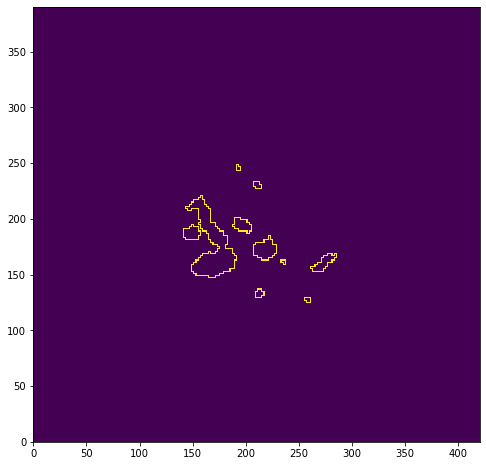

In [77]:
#check land contour
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.pcolor(landborder)

In [88]:
print(land)

(array([125, 125, 125, 125, 125, 126, 126, 127, 127, 127, 127, 128, 128,
       129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 130, 130, 131, 131, 131, 131, 132, 132, 133, 133, 134, 134,
       135, 135, 135, 135, 135, 135, 136, 136, 137, 137, 137, 137, 137,
       147, 147, 147, 147, 147, 147, 147, 148, 148, 149, 149, 149, 149,
       149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
       149, 150, 150, 151, 151, 151, 151, 151, 151, 151, 151, 152, 152,
       153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153,
       153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 155,
       155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 156, 156,
       156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158,
       158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159,
       159, 160, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 161,
       161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 1